In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid

from ekarus.e2e.single_stage_ao_class import SingleStageAO


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def define_target_roi(pupil, iwa, owa, oversampling:int, symmetric:bool=False):
    mask_shape = max(pupil.shape)
    padded_pupil = xp.pad(1-pupil.copy(), pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)
    X,Y = image_grid(padded_pupil.shape,recenter=True)
    rho = xp.sqrt(X**2+Y**2)
    if symmetric is True:
        where = (rho <= owa*oversampling) * (rho >= iwa*oversampling)
    else:
        where = (rho <= owa*oversampling) * (X >= iwa*oversampling) 
    return where

def define_apodizing_phase(pupil, res_phi_in_rad, roi, R, IF,
                           oversampling:int, max_its:int=200,
                           initial_guess=None, gain:float=0.1,
                           show_step:int=None):
    mask_shape = max(pupil.shape)
    pad_width = int((mask_shape*(oversampling-1)//2))
    padded_pupil = xp.pad(1-pupil, pad_width=pad_width, mode='constant', constant_values=0.0)

    phi = reshape_on_mask(res_phi_in_rad, (pupil).astype(bool))
    # res_phi = xp.pad(phi, pad_width=pad_width, mode='constant', constant_values=0.0)
    # field = xp.exp(1j*res_phi,dtype=xp.complex64)
    # focal_field = xp.fft.fftshift(xp.fft.fft2(field))
    # ref_psf = xp.abs(focal_field)**2    
    field = (1-pupil) * xp.exp(1j*phi,dtype=xp.complex64)
    pad_field = xp.pad(field, pad_width=pad_width, mode='constant', constant_values=0.0)
    focal_field = xp.fft.fftshift(xp.fft.fft2(pad_field))
    ref_psf = xp.abs(focal_field)**2

    dm_phase = initial_guess if initial_guess is not None else xp.zeros_like(res_phi_in_rad)
    roi_contrast = xp.zeros([3,max_its])
    best_contrast = 0
    best_phase = dm_phase.copy()

    for j in range(max_its):
        phi = reshape_on_mask(res_phi_in_rad+dm_phase, (pupil).astype(bool))
        # dm_phi = xp.pad(phi, pad_width=pad_width, mode='constant', constant_values=0.0)
        # field = xp.exp(1j*dm_phi,dtype=xp.complex64)
        # focal_field = xp.fft.fftshift(xp.fft.fft2(field))
        field = (1-pupil) * xp.exp(1j*phi,dtype=xp.complex64)
        pad_field = xp.pad(field, pad_width=pad_width, mode='constant', constant_values=0.0)
        focal_field = xp.fft.fftshift(xp.fft.fft2(pad_field))
        ff_roi = focal_field * roi
        pup_field_roi = xp.fft.ifft2(xp.fft.ifftshift(ff_roi))
        phase = xp.angle(pup_field_roi)[padded_pupil>0.0]
        cmd = R @ phase
        rec_phi = IF @ cmd

        contrast = xp.log10(xp.abs(focal_field)**2/xp.max(ref_psf))
        roi_contrast[0,j] = xp.max(contrast[roi])
        roi_contrast[1,j] = xp.mean(contrast[roi]) 
        roi_contrast[2,j] = xp.min(contrast[roi])

        if xp.mean(contrast[roi]) < best_contrast:
            best_contrast = xp.mean(contrast[roi]) 
            best_phase = dm_phase.copy()

        if show_step is not None:
            if j % show_step == 0:
                plt.figure(figsize=(20,4))        
                plt.subplot(1,4,1)
                plt.imshow(masked_array(xp.asnumpy(phi),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
                plt.colorbar()
                plt.title('Field + DM phase')
                plt.subplot(1,4,4)
                plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(rec_phi,(pupil).astype(bool))),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
                plt.colorbar()
                plt.title('Reconstructed DM phase')
                plt.subplot(1,4,3)
                plt.imshow(masked_array(xp.asnumpy(contrast),mask=xp.asnumpy(1-roi)),
                        origin='lower',cmap='twilight',vmin=-12,vmax=0)
                cbar=plt.colorbar()
                cbar.ax.set_title('Contrast')
                plt.xlim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.ylim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.title(f'ROI average contrast: {xp.mean(contrast[roi]):1.1f}')
                plt.subplot(1,4,2)
                plt.imshow(xp.asnumpy(contrast),origin='lower',cmap='twilight',vmin=-12,vmax=0)
                cbar=plt.colorbar()
                cbar.ax.set_title('Contrast')
                plt.xlim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.ylim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.title(f'PSF\nIteration {j:1.0f}')
        dm_phase -= gain * rec_phi

    return best_phase, roi_contrast

In [3]:
def calc_psf(ef, oversampling:int=8):
    pad_width = int((max(ef.shape)*(oversampling-1)//2))
    pad_ef = xp.pad(ef, pad_width=pad_width, mode='constant', constant_values=0.0)
    ff = xp.fft.fftshift(xp.fft.fft2(pad_ef))
    return xp.real(ff * xp.conj(ff))

def show_psf(psf, norm=None, oversampling:int=8, title:str='', ext=0.3, vmin=-10):
    pixelSize = 1/oversampling
    imageHalfSizeInPoints= psf.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-ext)), int(imageHalfSizeInPoints*(1+ext))]
    psfZoom = psf[roi[0]: roi[1], roi[0]:roi[1]]
    sz = psfZoom.shape
    if norm is None:
        norm = xp.max(psf)
    plt.imshow(xp.asnumpy(xp.log10(psfZoom/norm)), extent=
               [-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
               -sz[1]/2*pixelSize, sz[1]/2*pixelSize],
               origin='lower',cmap='inferno',vmin=vmin,vmax=0)
    plt.xlabel(r'$\lambda/D$')
    plt.ylabel(r'$\lambda/D$')
    cbar= plt.colorbar()
    cbar.ax.set_title('Contrast')
    plt.title(title)

In [4]:
ssao = SingleStageAO('offaxis_8m')
atmo_phases,res_phases = ssao.load_telemetry_data(data_keys=['mag7_atmo_phases','mag7_residual_phases'])

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps


Text(0.5, 1.0, 'Residual phase in [rad]')

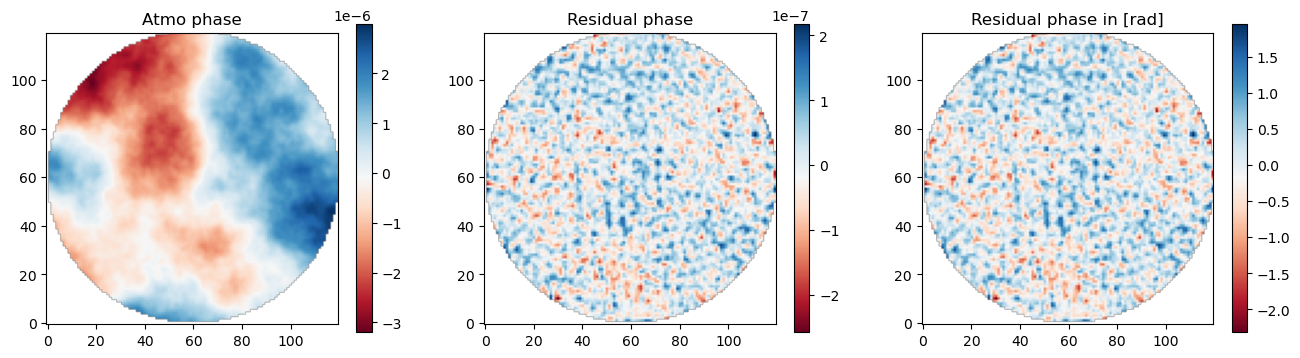

In [5]:
id = 100
m2rad = 2*xp.pi/ssao.pyr.lambdaInM
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(atmo_phases[id].data,atmo_phases[id].mask),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Atmo phase')
plt.subplot(1,3,2)
plt.imshow(masked_array(res_phases[id].data,res_phases[id].mask),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Residual phase')
plt.subplot(1,3,3)
plt.imshow(masked_array(res_phases[id].data*m2rad,res_phases[id].mask),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Residual phase in [rad]')

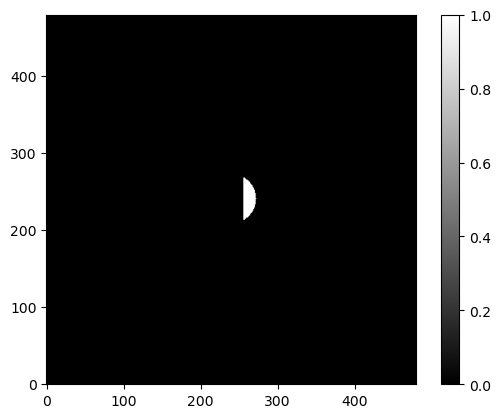

In [6]:
iwaInLambdaOverD = 4
owaInLambdaOverD = 8
oversampling = 4
pupil = ssao.cmask.copy()

roi = define_target_roi(pupil, iwaInLambdaOverD, owaInLambdaOverD, oversampling)
plt.figure()
plt.imshow(xp.asnumpy(roi),origin='lower',cmap='gray')
plt.colorbar()

In [23]:
phi = xp.asarray(res_phases[id].data)*m2rad
res_phi_in_rad = phi[~pupil]

IF = ssao.dm.IFF.T
R = xp.linalg.pinv(IF)
dm_phi_in_rad, roi_contrast = define_apodizing_phase(pupil, 
                                  res_phi_in_rad, roi, IF, R, 
                                  oversampling=oversampling, max_its=1000, 
                                  gain=0.002)#, show_step=30)

(11277, 1141) (11277,)


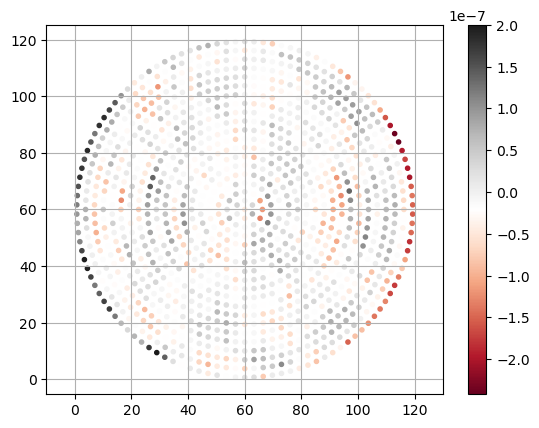

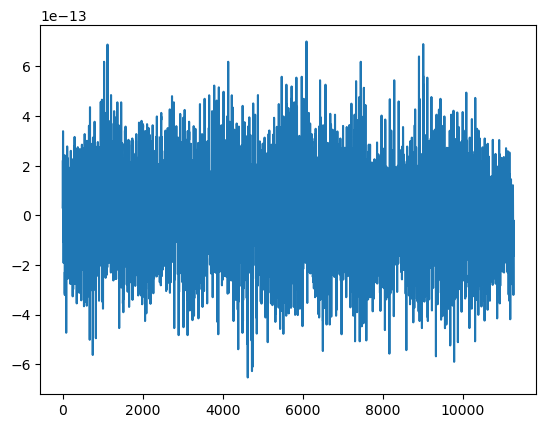

In [ ]:
# print(R.shape, dm_phi_in_rad.shape)

# dm_cmd = R.T @ dm_phi_in_rad/m2rad
# rec_phi = IF.T @ dm_cmd
# delta_phi = rec_phi - dm_phi_in_rad/m2rad

# plt.figure()
# ssao.dm.plot_position(dm_cmd)

# plt.figure()
# plt.plot(xp.asnumpy(delta_phi))

Text(0.5, 1.0, 'Contrast in dark zone')

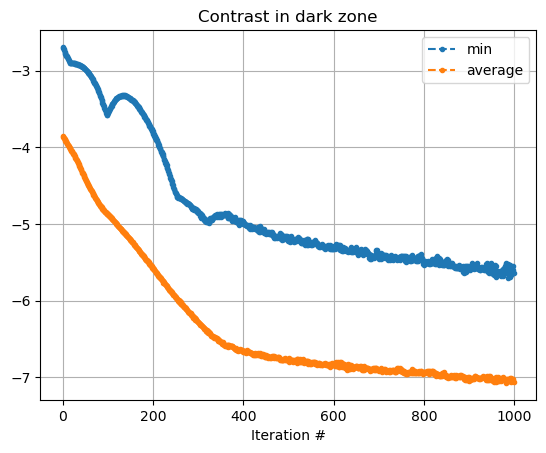

In [24]:
plt.figure()
plt.plot(xp.asnumpy(roi_contrast[0]),'--.',label='min')
plt.plot(xp.asnumpy(roi_contrast[1]),'--.',label='average')
# plt.plot(xp.asnumpy(roi_contrast[2]),'--.',label='max')
plt.legend()
plt.grid()
plt.xlabel('Iteration #')
plt.title('Contrast in dark zone')

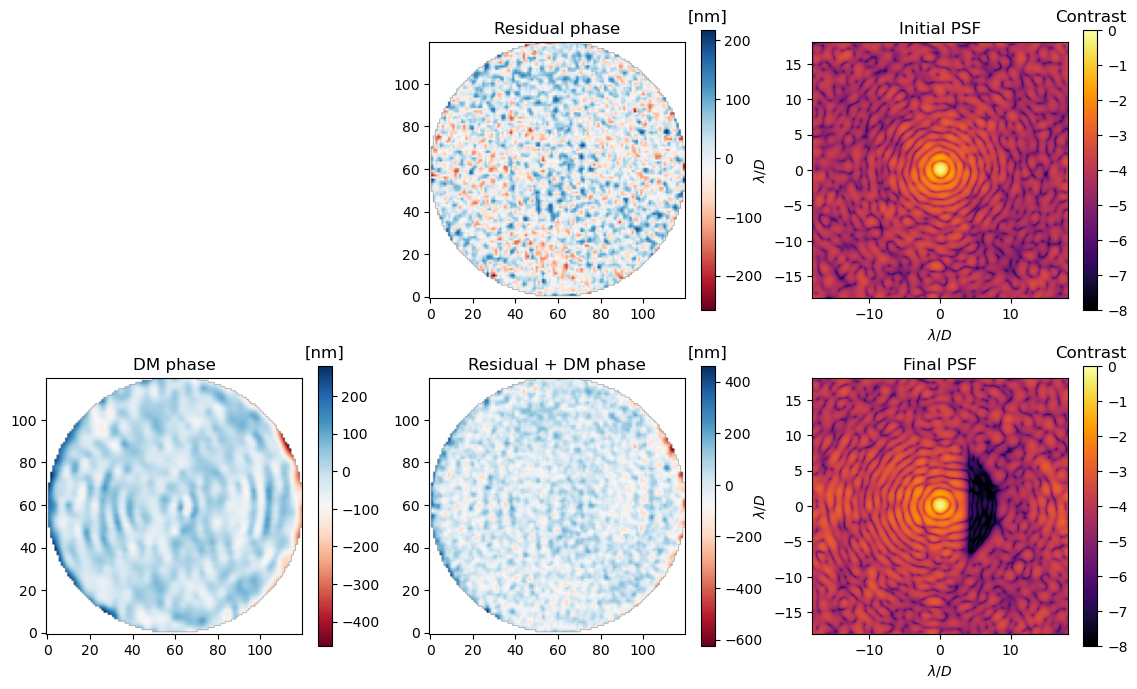

In [14]:
res_phi_2d = reshape_on_mask(res_phi_in_rad,pupil)
dm_phi_2d = reshape_on_mask(dm_phi_in_rad,pupil)

psf_oversampling = 12

dl_ef = (1-pupil) * xp.exp(1j*res_phi_2d*0,dtype=xp.complex64)
res_ef = (1-pupil) * xp.exp(1j*res_phi_2d,dtype=xp.complex64)
ef = (1-pupil) * xp.exp(1j*(res_phi_2d+dm_phi_2d),dtype=xp.complex64)

dl_psf = calc_psf(dl_ef, oversampling=psf_oversampling)
res_psf = calc_psf(res_ef, oversampling=psf_oversampling)
psf = calc_psf(ef, oversampling=psf_oversampling)

plt.figure(figsize=(14,8))
plt.subplot(2,3,2)
plt.imshow(masked_array(xp.asnumpy(res_phi_2d/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
cbar=plt.colorbar()
cbar.ax.set_title('[nm]')
plt.title('Residual phase')
plt.subplot(2,3,4)
plt.imshow(masked_array(xp.asnumpy(dm_phi_2d/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
cbar=plt.colorbar()
cbar.ax.set_title('[nm]')
plt.title('DM phase')
plt.subplot(2,3,5)
plt.imshow(masked_array(xp.asnumpy((dm_phi_2d+res_phi_2d)/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
cbar=plt.colorbar()
cbar.ax.set_title('[nm]')
plt.title('Residual + DM phase')
plt.subplot(2,3,6)
show_psf(psf, norm=xp.max(dl_psf), oversampling=psf_oversampling, title='Final PSF', vmin=-8)
plt.subplot(2,3,3)
show_psf(res_psf, norm=xp.max(dl_psf), oversampling=psf_oversampling, title='Initial PSF', vmin=-8)

In [ ]:
Nits = 20
step=1

for i in range(Nits):
    phi = xp.asarray(res_phases[id+i*step].data)*m2rad
    res_phi_in_rad = phi[~pupil]

    dm_phi_in_rad, roi_contrast = define_apodizing_phase(pupil, 
                                    res_phi_in_rad, roi, IF, R, 
                                    oversampling=oversampling, max_its=10, 
                                    gain=0.2)
    
    dm_cmd = R.T @ dm_phi_in_rad/m2rad
    dm_phi_2d = reshape_on_mask(dm_phi_in_rad,pupil)
    ef = (1-pupil) * xp.exp(1j*(phi+dm_phi_2d),dtype=xp.complex64)
    psf = calc_psf(ef, oversampling=psf_oversampling)

    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    plt.imshow(masked_array(xp.asnumpy(res_phi_2d/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
    plt.axes('off')
    cbar=plt.colorbar()
    cbar.ax.set_title('[nm]')
    plt.title('Residual phase')
    plt.subplot(1,4,2)
    ssao.dm.plot_position(dm_cmd)
    plt.title('DM phase')
    plt.subplot(1,4,3)
    plt.imshow(masked_array(xp.asnumpy((dm_phi_2d+res_phi_2d)/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
    cbar=plt.colorbar()
    cbar.ax.set_title('[nm]')
    plt.title('Residual + DM phase')
    plt.subplot(1,4,4)
    show_psf(psf, norm=xp.max(dl_psf), oversampling=psf_oversampling, title='PSF', vmin=-8)
    

In [10]:
# phi = (res_phases[id].data[~res_phases[id].mask])/10
# app, _ = get_apo_phase(pupil, show=True, beta=0.98, residual_phase_in_rad=phi*m2rad, guess_phase_in_rad=app_ref[~pupil.astype(bool)])

In [11]:
# guess = app_ref[~pupil.astype(bool)]
# damp = 7
# step = 1
# mask_shape = max(pupil.shape)
# oversampling = 8
# padded_pupil = xp.pad(1-pupil.copy(), pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)

# for jj in range(20):
#     phi = xp.asarray(res_phases[id+jj*step].data[~res_phases[id+jj*step].mask])/damp*m2rad
#     phi = xp.angle(xp.exp(1j*phi)) # wrap to pi
#     if jj % 10 == 1:
#         phase = reshape_on_mask(phi, pupil)
#         pad_phase = xp.pad(phase+app, pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)
#         input_field = padded_pupil * xp.exp(1j*pad_phase,dtype=xp.complex64)
#         focal_field = xp.fft.fftshift(xp.fft.fft2(input_field))
#         psf = xp.real(focal_field*xp.conj(focal_field))
#         plt.figure(figsize=(16,4))
#         plt.subplot(1,3,3)
#         showZoomCenter(psf, 1/oversampling, title='Apodized PSF', xlabel=r'$\lambda/D$', ylabel=r'$\lambda/D$', cmap='twilight')
#         plt.subplot(1,3,1)
#         plt.imshow(masked_array(xp.asnumpy(app),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
#         plt.colorbar()
#         plt.title('Apodizer phase [rad]')
#         plt.subplot(1,3,2)
#         plt.imshow(masked_array(res_phases[id+jj*step].data*m2rad, mask=res_phases[id+jj*step].mask),origin='lower',cmap='RdBu')
#         plt.colorbar()
#         plt.title('Residual phase [rad]')
#     app, flag = get_apo_phase(pupil, show=False, beta=0.3, max_its=20, residual_phase_in_rad=phi, guess_phase_in_rad=guess.copy())
#     if flag == 0:
#         guess = app[~pupil.astype(bool)].copy()